# **Data Analytics Programming Assignment**
This assignment is a test of your algorithmic thinking. You can use any A.I. tools ot assist you in this coding assignment.

Instructions:
- This is done by pair, preferably your thesis partner.
- Each person should create a Github Repo titled 'Assignment_1_Data_Analytics'.
- Read the journal provided.
- Develop a Python implementation of the procedures in the journal.
- Deadline is before premidterm week.

---

## **🎯 Objective**  

To implement the procedures described in the journal:  
📖 *"Balanced Risk Set Matching"* by **Yunfei Paul Li, Kathleen J. Propert & Paul R. Rosenbaum.*  

---

## **📌 Approach to the Assignment**  

To implement the procedures from the journal *"Balanced Risk Set Matching"* by Yunfei Paul Li, Kathleen J. Propert, and Paul R. Rosenbaum, we followed a structured and algorithmic approach:

**🔹 Understanding the Journal**  
**🔹 Data Preparation**  
**🔹 Matching Procedure**  
**🔹 Assessing Matching Quality**  
**🔹 Longitudinal Symptom Analysis**  
**🔹 Visualization & Interpretation**  

# **Import needed libraries**

In [487]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import wilcoxon
from scipy.spatial.distance import mahalanobis
from scipy.spatial.distance import cdist
from pulp import LpMinimize, LpProblem, LpVariable, lpSum
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# **Generate Synthetic Data**

Since we don't have access to the actual dataset used in the journal, we replicate the variables that were mentioned:

- Generated synthetic data and store it into data.csv
- Load the data

In [488]:
df = pd.read_csv("./data/data.csv")
print(df.head())
print(df.shape)

   Patient_ID  Enrollment_Time  Treatment_Time  Treated  base_pain  \
0           1                6            15.0      1.0          0   
1           2                3             inf      0.0          8   
2           3               10             inf      0.0          5   
3           4                7             inf      0.0          6   
4           5                4             inf      0.0          9   

   base_urgency  base_frequency  treatment_pain  treatment_urgency  \
0             1              13               0                  2   
1             5              13               6                  4   
2             4              10               5                  3   
3             1              15               7                  1   
4             2               3               9                  1   

   treatment_frequency  Pain_3M  Urgency_3M  Frequency_3M  Pain_6M  \
0                   14        0           0            12        0   
1                 

# **Extracting & Preprocessing for Distance Calculation**  

1️⃣ **Split Groups:** Treated (`Treated == 1`) & Control (`Treated == 0`).  
2️⃣ **Select Covariates:** Baseline & Post-Treatment symptoms.  
3️⃣ **Standardize Data:** Normalize using `StandardScaler`.  
4️⃣ **Compute Covariance Matrix:** Capture variable relationships.  
5️⃣ **Calculate Inverse Matrix:** Needed for Mahalanobis Distance.

In [489]:
# Extract treated and control groups
treated = df[df["Treated"] == 1].copy()
control = df[df["Treated"] == 0].copy()

# Standardize covariates for Mahalanobis distance calculation
covariates = ["base_pain", "base_urgency", "base_frequency",
              "treatment_pain", "treatment_urgency", "treatment_frequency"]

scaler = StandardScaler()
treated_scaled = scaler.fit_transform(treated[covariates])
control_scaled = scaler.transform(control[covariates])

# Compute inverse covariance matrix for Mahalanobis distance
cov_matrix = np.cov(treated_scaled.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# 🔍 **Mahalanobis Distance & Feasible Matches**  

1️⃣ **Compute Mahalanobis Distance** using standardized covariates.  


In [490]:
def compute_mahalanobis_dataframe(treated, control, covariates, scaler, inv_cov_matrix, threshold=2):
    treated_scaled = scaler.transform(treated[covariates])
    control_scaled = scaler.transform(control[covariates])

    # Compute distances using a vectorized approach
    distances = cdist(treated_scaled, control_scaled, metric='mahalanobis', VI=inv_cov_matrix)

    # Convert distances to DataFrame & filter by threshold
    treated_ids, control_ids = np.where(distances <= threshold)
    distance_values = distances[treated_ids, control_ids]

    distance_df = pd.DataFrame({
        "Treated_Patient": treated.index[treated_ids].astype(int),  # Ensure integer IDs
        "Control_Patient": control.index[control_ids].astype(int),
        "Mahalanobis_Distance": distance_values
    })

    return distance_df

# Automatically find the right threshold to ensure 100 matches
threshold = 1
while True:
    distance_df = compute_mahalanobis_dataframe(treated, control, covariates, scaler, inv_cov_matrix, threshold)
    if len(distance_df) >= 100:
        break  # Stop once we have enough feasible pairs
    threshold += 0.5  # Increase threshold dynamically

print(f"Final Mahalanobis distance threshold used: {threshold}")
print(f"Total Feasible Matches Found: {len(distance_df)}")
print(distance_df.head())


Final Mahalanobis distance threshold used: 1.5
Total Feasible Matches Found: 489
   Treated_Patient  Control_Patient  Mahalanobis_Distance
0                0              321              0.980644
1                0              361              1.410502
2                0              376              0.497878
3                6               11              1.043003
4                6               13              1.175307


# 🎯 **Optimal Pair Matching**  

Match **treated & control** patients **optimally** by minimizing **Mahalanobis distance** 

2️⃣ **Minimize Total Mahalanobis Distance**.  
3️⃣ **Apply Constraints** → Each patient matched **only once**.  
4️⃣ **Solve with Linear Programming (PuLP)**.  
5️⃣ **Extract & Display Matches**.  

In [491]:
def optimal_match(distance_df, max_pairs=100):
    prob = LpProblem("Optimal_Pair_Matching", LpMinimize)

    # Decision variables: x[i, j] = 1 if treated i is matched to control j
    x = {(i, j): LpVariable(f"x_{i}_{j}", cat="Binary") for i, j in zip(distance_df["Treated_Patient"], distance_df["Control_Patient"])}

    # Objective: Minimize the sum of Mahalanobis distances
    prob += lpSum(x[i, j] * distance_df[(distance_df["Treated_Patient"] == i) & (distance_df["Control_Patient"] == j)]["Mahalanobis_Distance"].values[0]
                  for i, j in x), "Total_Distance"

    # Constraint: Each treated patient can be matched to only one control
    for i in distance_df["Treated_Patient"].unique():
        prob += lpSum(x[i, j] for j in distance_df[distance_df["Treated_Patient"] == i]["Control_Patient"]) <= 1

    # Constraint: Each control patient can be matched to only one treated patient
    for j in distance_df["Control_Patient"].unique():
        prob += lpSum(x[i, j] for i in distance_df[distance_df["Control_Patient"] == j]["Treated_Patient"]) <= 1

    # Constraint: Limit to 100 matched pairs
    prob += lpSum(x[i, j] for i, j in x) == max_pairs

    # Solve the problem
    prob.solve()

    # Extract matched pairs
    matched_pairs = [(i, j) for (i, j), var in x.items() if var.varValue == 1]

    return pd.DataFrame(matched_pairs, columns=["Treated_Patient", "Control_Patient"])

# Get 100 optimally matched pairs
matched_pairs = optimal_match(distance_df, max_pairs=100)

print("\nFinal Matched Pairs (100 total):")
print(matched_pairs.head(15))
print(f"Total Matched Pairs: {len(matched_pairs)}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/f5/1rj7cjgn3sqclq_6hndg5q9m0000gn/T/dd1ff58825274dbca80cbecadea989e0-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/f5/1rj7cjgn3sqclq_6hndg5q9m0000gn/T/dd1ff58825274dbca80cbecadea989e0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 3282 RHS
At line 3626 BOUNDS
At line 4116 ENDATA
Problem MODEL has 343 rows, 489 columns and 1467 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 98.8313 - 0.00 seconds
Cgl0004I processed model has 239 rows, 455 columns (455 integer (455 of which binary)) and 1295 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 98.8313
Cbc0038I Before mini branch 

# 📏 **Evaluating Matching Quality**  

Assess **matching effectiveness** by comparing **Mahalanobis distance** before & after matching.  

1️⃣ **Standardize Covariates** for comparison.  
2️⃣ **Compute Mahalanobis Distance** for treated-control pairs.  
3️⃣ **Compare Pre- & Post-Matching Distances**—**lower is better!**  


In [492]:
# Function to compute average Mahalanobis distance
def compute_mahalanobis_dist(group1, group2, covariates):
    X1 = group1[covariates].values
    X2 = group2[covariates].values

    # Standardize data
    scaler = StandardScaler()
    X1_scaled = scaler.fit_transform(X1)
    X2_scaled = scaler.transform(X2)

    # Compute covariance matrix and inverse
    cov_matrix = np.cov(np.vstack((X1_scaled, X2_scaled)).T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # Compute Mahalanobis distance for each treated-control pair
    distances = []
    for i in range(len(X1_scaled)):
        dist = mahalanobis(X1_scaled[i], X2_scaled[i % len(X2_scaled)], inv_cov_matrix)
        distances.append(dist)
    
    return np.mean(distances)  # Return average Mahalanobis distance

# Extract treated and control groups
treated = df[df["Treated"] == 1].copy()
control = df[df["Treated"] == 0].copy()

# Compute Mahalanobis distance before matching
mahal_before = compute_mahalanobis_dist(treated, control, covariates)

# Extract matched treated and control patients
treated_matched = df.loc[matched_pairs["Treated_Patient"]]
control_matched = df.loc[matched_pairs["Control_Patient"]]

# Compute Mahalanobis distance after matching
mahal_after = compute_mahalanobis_dist(treated_matched, control_matched, covariates)

# Print Results
print(f"Mahalanobis Distance Before Matching: {mahal_before:.3f}")
print(f"Mahalanobis Distance After Matching: {mahal_after:.3f}")


Mahalanobis Distance Before Matching: 3.418
Mahalanobis Distance After Matching: 1.021


# 📊 **Preparing Data for Visualization**  

### 🎯 Extract and structure **symptom measurements** from matched pairs for **analysis & plotting**.  

1️⃣ **Extract Symptom Values** at **Baseline, Treatment, 3M, & 6M**.  
2️⃣ **Compute Changes (3M & 6M)** from **pre-treatment averages**.  
3️⃣ **Build a Long-Form DataFrame** for easy visualization.  

### 📌 **Time Points Considered:**  
✔️ **Baseline** (Pre-treatment)  
✔️ **Treatment Time**  
✔️ **3M & 6M Post-Treatment**  
✔️ **Symptom Changes (3M & 6M)**  

In [493]:
# Prepare Data for Graphical Representation
def extract_measurements(pair_list, variable, timepoint):
    vals = []
    for i, j in pair_list:
        if timepoint in ['change_3M', 'change_6M']:
            # Compute pre-treatment averages
            treated_pretreat_avg = (df.loc[i, f'base_{variable}'] + df.loc[i, f'treatment_{variable}']) / 2.0
            control_pretreat_avg = (df.loc[j, f'base_{variable}'] + df.loc[j, f'treatment_{variable}']) / 2.0

            # Get post-treatment values using correct capitalization
            post_treatment_tp = f"{variable.capitalize()}_3M" if timepoint == "change_3M" else f"{variable.capitalize()}_6M"
            
            # Verify if the column exists
            if post_treatment_tp not in df.columns:
                raise KeyError(f"Column '{post_treatment_tp}' not found in DataFrame. Available columns: {df.columns}")

            treated_post = df.loc[i, post_treatment_tp]
            control_post = df.loc[j, post_treatment_tp]

            # Compute differences from pre-treatment average
            treated_diff = treated_post - treated_pretreat_avg
            control_diff = control_post - control_pretreat_avg

            vals.append((treated_diff, control_diff))
        else:
            # Standard case for baseline, treatment, 3M, and 6M values
            column_mapping = {
                'baseline': f'base_{variable}',
                'treatment': f'treatment_{variable}',
                '3M': f'{variable.capitalize()}_3M',
                '6M': f'{variable.capitalize()}_6M'
            }
            column_name = column_mapping.get(timepoint)

            if column_name not in df.columns:
                raise KeyError(f"Column '{column_name}' not found in DataFrame. Available columns: {df.columns}")

            vals.append((df.loc[i, column_name], df.loc[j, column_name]))
    
    return np.array(vals)

# Convert DataFrame to list of tuples
pair_list = list(matched_pairs.itertuples(index=False, name=None))

# Define the variables and time points for plotting
variables = ['pain', 'urgency', 'frequency']
timepoints = ['baseline', 'treatment', '3M', '6M', 'change_3M', 'change_6M']
timepoint_labels = {
    'baseline': 'Baseline',
    'treatment': 'At Treatment',
    '3M': '3 Months after Treatment',
    '6M': '6 Months after Treatment',
    'change_3M': 'Difference (3 mos posttreatment)',
    'change_6M': 'Difference (6 mos posttreatment)'
}

# Build a long-form DataFrame
plot_data = []
for var in variables:
    for tp in timepoints:
        measurements = extract_measurements(pair_list, var, tp)
        if tp in ['change_3M', 'change_6M']:
            # Store treated and control differences
            for idx in range(measurements.shape[0]):
                plot_data.append({
                    'Variable': var.capitalize(),
                    'TimePoint': timepoint_labels[tp],
                    'Group': 'Treated',
                    'Value': measurements[idx, 0]  # Treated difference
                })
                plot_data.append({
                    'Variable': var.capitalize(),
                    'TimePoint': timepoint_labels[tp],
                    'Group': 'Never/Later Treated',
                    'Value': measurements[idx, 1]  # Control difference
                })
        else:
            # Store standard Treated and Control values
            for idx in range(measurements.shape[0]):
                plot_data.append({
                    'Variable': var.capitalize(),
                    'TimePoint': timepoint_labels[tp],
                    'Group': 'Treated',
                    'Value': measurements[idx, 0]
                })
                plot_data.append({
                    'Variable': var.capitalize(),
                    'TimePoint': timepoint_labels[tp],
                    'Group': 'Never/Later Treated',
                    'Value': measurements[idx, 1]
                })

plot_df = pd.DataFrame(plot_data)

# 📊 **Standardized Mean Difference (SMD) & Statistical Comparison**  

This analysis evaluates the balance between matched **treated** and **control** groups using **Standardized Mean Difference (SMD)** and **t-tests** to ensure comparability.  

### ⚡ **Key Steps**  
1️⃣ **Compute Standardized Mean Difference (SMD)**  
&nbsp;&nbsp;&nbsp;&nbsp;✔️ Measures the difference in means relative to pooled standard deviation.  
&nbsp;&nbsp;&nbsp;&nbsp;✔️ Ensures balance between matched groups.  

2️⃣ **Extract Matched Groups**  
&nbsp;&nbsp;&nbsp;&nbsp;✔️ Select **Treated** and **Control** patients from matched pairs.  

3️⃣ **Perform t-tests on Covariates**  
&nbsp;&nbsp;&nbsp;&nbsp;✔️ Checks for **statistically significant differences** between groups.  
&nbsp;&nbsp;&nbsp;&nbsp;✔️ Reports **p-values** to assess equality of means.  

In [494]:
# Function to calculate Standardized Mean Difference (SMD)
def compute_smd(treated_group, control_group, covariates):
    smd_results = {}
    for cov in covariates:
        mean_treated = treated_group[cov].mean()
        mean_control = control_group[cov].mean()
        pooled_std = np.sqrt((treated_group[cov].std()**2 + control_group[cov].std()**2) / 2)
        smd = np.abs(mean_treated - mean_control) / pooled_std
        smd_results[cov] = smd
    return smd_results

# Extract matched treated and control patients
matched_treated = df.loc[matched_pairs["Treated_Patient"]]
matched_control = df.loc[matched_pairs["Control_Patient"]]

# Compute Standardized Mean Differences (SMD)
smd_values = compute_smd(matched_treated, matched_control, covariates)

# Display SMD results
print("\nStandardized Mean Differences (SMD) for Matched Data:")
for cov, smd in smd_values.items():
    print(f"{cov}: {smd:.3f}")

# Check p-values using t-tests
print("\nT-test results (p-values) for matched groups:")
for cov in covariates:
    _, p_value = ttest_ind(matched_treated[cov], matched_control[cov], equal_var=False)
    print(f"{cov}: p-value = {p_value:.3f}")


Standardized Mean Differences (SMD) for Matched Data:
base_pain: 0.050
base_urgency: 0.064
base_frequency: 0.023
treatment_pain: 0.029
treatment_urgency: 0.065
treatment_frequency: 0.012

T-test results (p-values) for matched groups:
base_pain: p-value = 0.725
base_urgency: p-value = 0.651
base_frequency: p-value = 0.869
treatment_pain: p-value = 0.837
treatment_urgency: p-value = 0.647
treatment_frequency: p-value = 0.930


## 📊 **Matched Group Comparison: Treated vs. Control (After Matching)**  

Visualizing the distribution of covariates **after matching** between **Treated** and **Control** groups.  

- **Side-by-side bar plots** for **Treated (🔵 Blue)** and **Control (🔴 Red)** groups.  
- Shows **how well the matching process balanced the covariates**.  
- Helps assess **post-matching comparability** before analysis.  

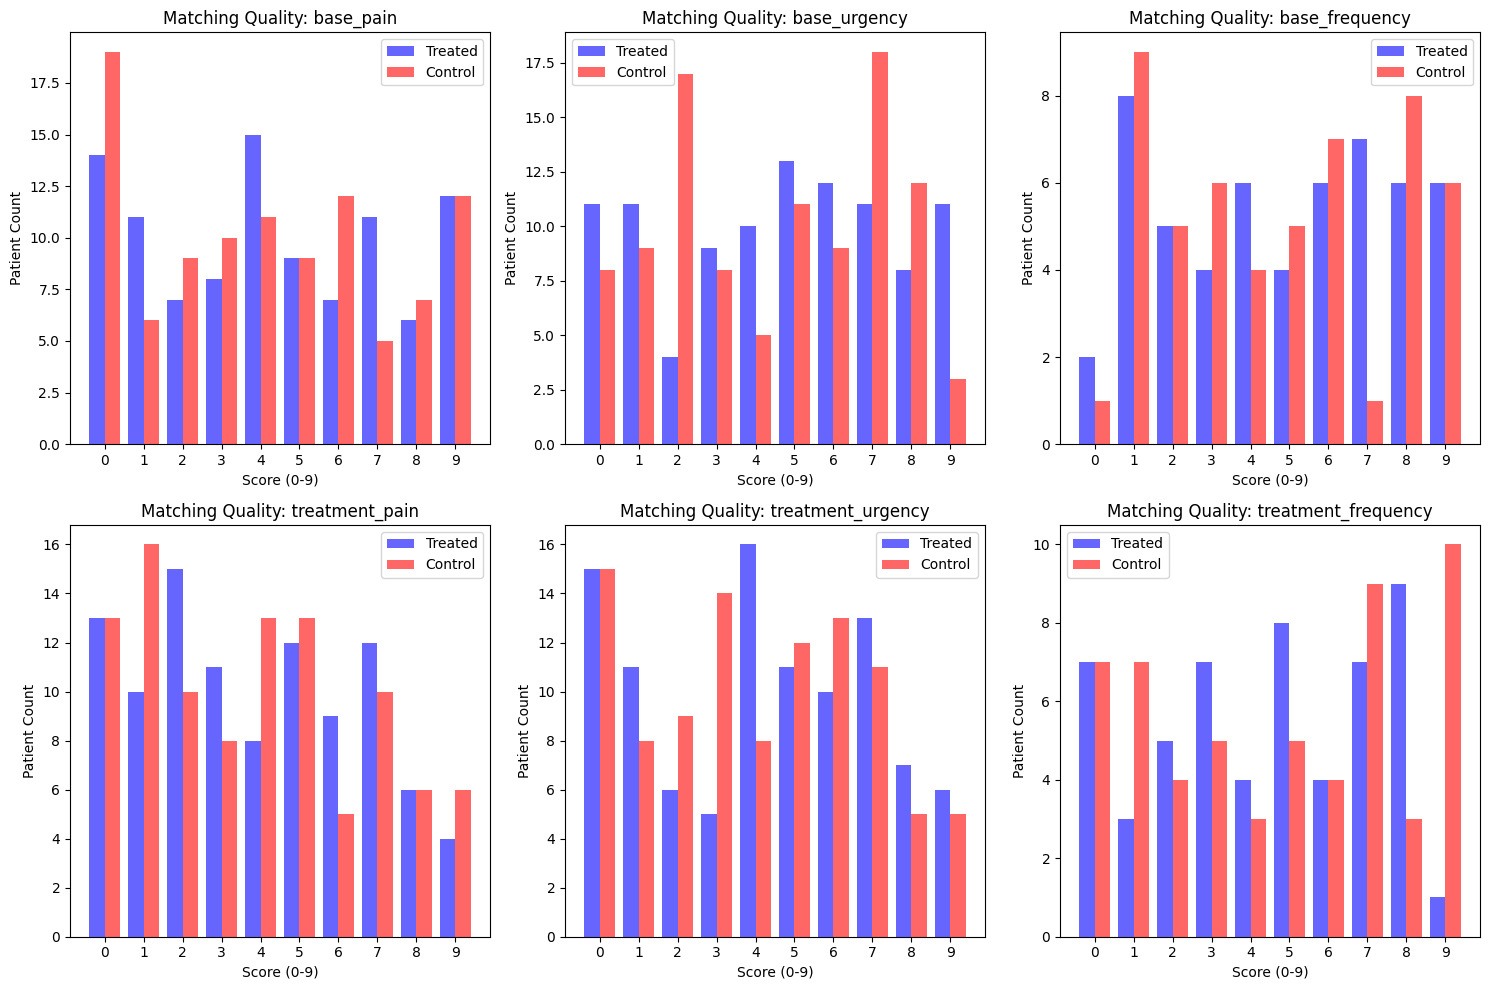

In [495]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, cov in enumerate(covariates):
    # Get distributions
    treated_after = matched_treated[cov].value_counts().sort_index()
    control_after = matched_control[cov].value_counts().sort_index()

    # Reindex for consistency
    index_range = range(10)
    treated_after = treated_after.reindex(index_range, fill_value=0)
    control_after = control_after.reindex(index_range, fill_value=0)

    # Bar width for grouped bars
    bar_width = 0.4

    # Create bar plots
    axes[i].bar(np.array(index_range) - bar_width / 2, treated_after, width=bar_width, color="blue", alpha=0.6, label="Treated")
    axes[i].bar(np.array(index_range) + bar_width / 2, control_after, width=bar_width, color="red", alpha=0.6, label="Control")

    # Formatting
    axes[i].set_title(f"Matching Quality: {cov}")
    axes[i].set_xlabel("Score (0-9)")
    axes[i].set_ylabel("Patient Count")
    axes[i].set_xticks(index_range)
    axes[i].legend()

plt.tight_layout()
plt.show()


# Graph Visualization

In [496]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_graph(variable):
    # Validate the input variable
    variable_lower = variable.lower()
    if variable_lower not in ['pain', 'urgency', 'frequency']:
        raise ValueError("Variable must be 'pain', 'urgency', or 'frequency'.")
    
    variable_cap = variable_lower.capitalize()
    data = plot_df[plot_df['Variable'] == variable_cap]
    
    # Create a 3x2 figure (6 subplots total)
    fig, axes = plt.subplots(3, 2, figsize=(4*3, 5*2), sharey=False)
    axes = axes.flatten()
    
    # First 4 timepoints
    timepoints_main = data['TimePoint'].unique()[:4]
    for j, tp in enumerate(timepoints_main):
        ax = axes[j]
        subdata = data[data['TimePoint'] == tp]
        sns.boxplot(x='Group', y='Value', data=subdata, ax=ax, width=0.3)
        ax.set_title(f"{tp}")
        ax.set_xlabel("")
        
        # Set ylabel based on the variable
        if variable_lower == 'pain':
            ax.set_ylabel("Pain Score")
        elif variable_lower == 'urgency':
            ax.set_ylabel("Urgency Score")
        else:
            ax.set_ylabel("Frequency Score")
        
        # Adjust ylim for frequency
        if variable_lower == 'frequency':
            ax.set_ylim(-0.5, 21)
        else:
            ax.set_ylim(-0.5, 9.5)
    
    # Last 2 timepoints (contrast differences)
    timepoints_diff = data['TimePoint'].unique()[-2:]
    for j, tp in enumerate(timepoints_diff, start=4):
        ax = axes[j]
        subdata = data[data['TimePoint'] == tp]
        sns.boxplot(x='Group', y='Value', data=subdata, ax=ax, width=0.3)
        ax.set_title(f"{tp}")
        ax.set_xlabel("")
        ax.set_ylabel("Difference from Pre-Treatment")
        ax.set_ylim(-6.5, 3.5)  # Adjust based on your data
    
    # Hide unused subplots (if any)
    for j in range(len(timepoints_main) + len(timepoints_diff), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

## Pain Graph

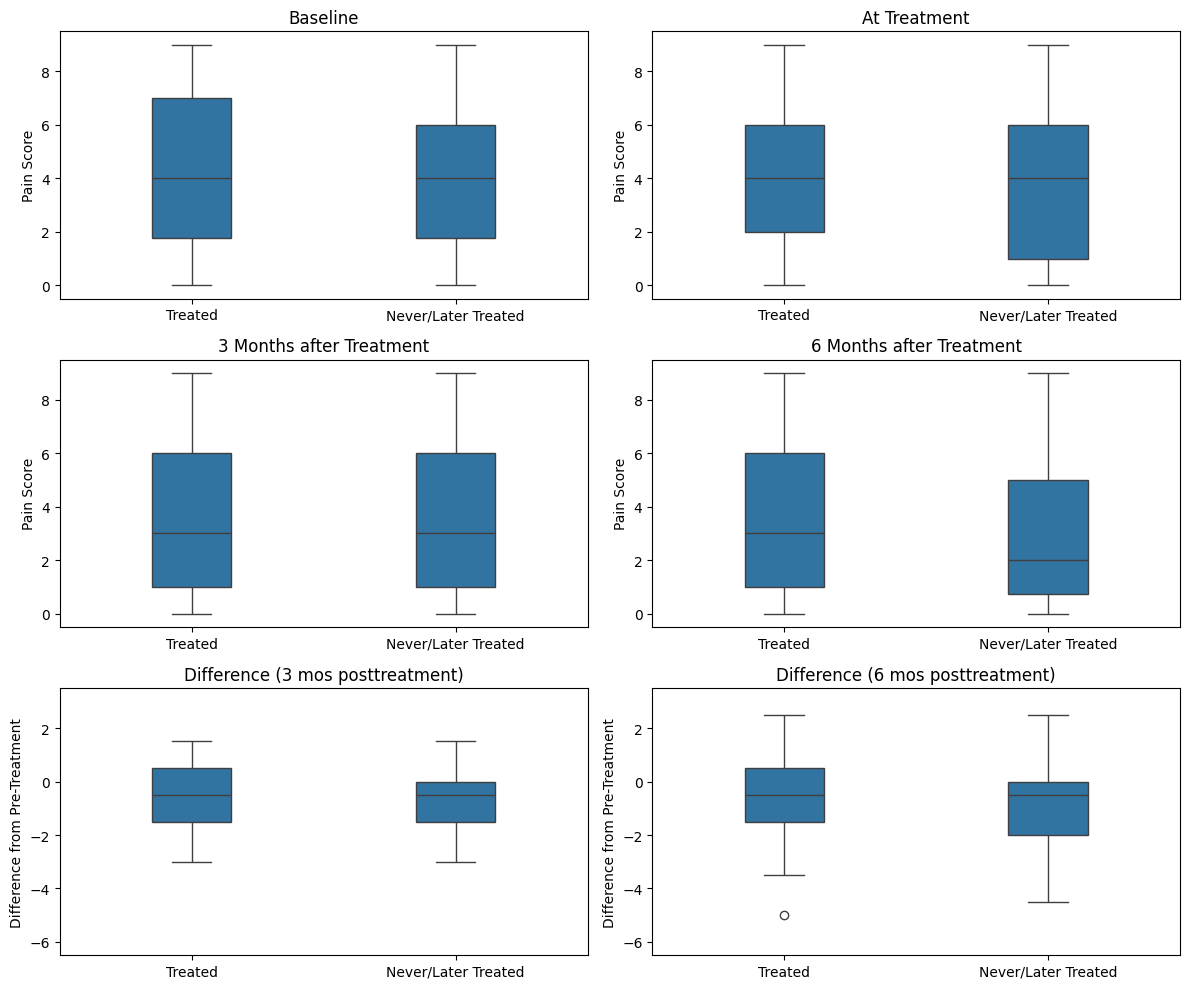

In [497]:
display_graph('pain')

## Urgency Graph

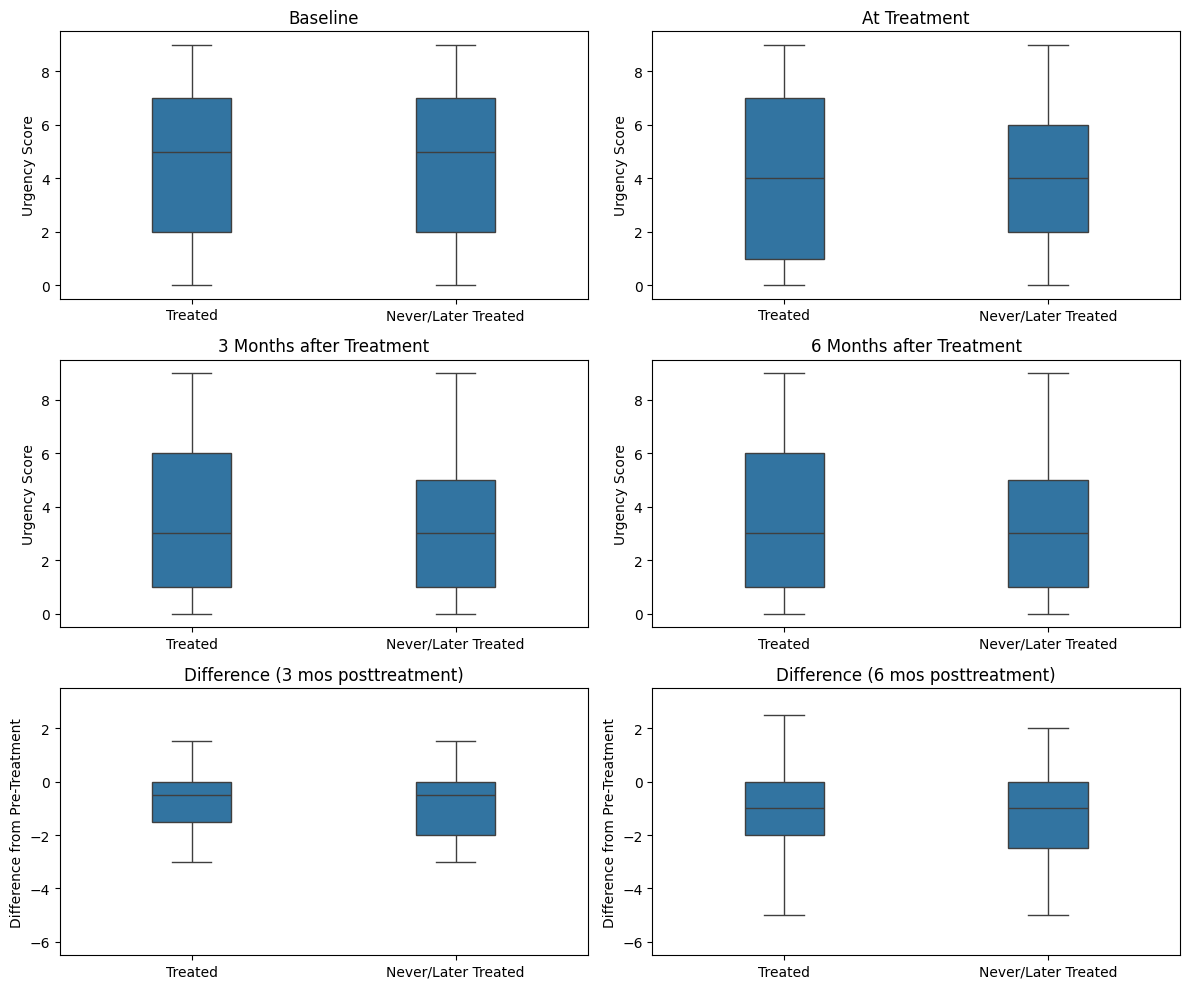

In [498]:
display_graph('urgency')

## Frequency Graph

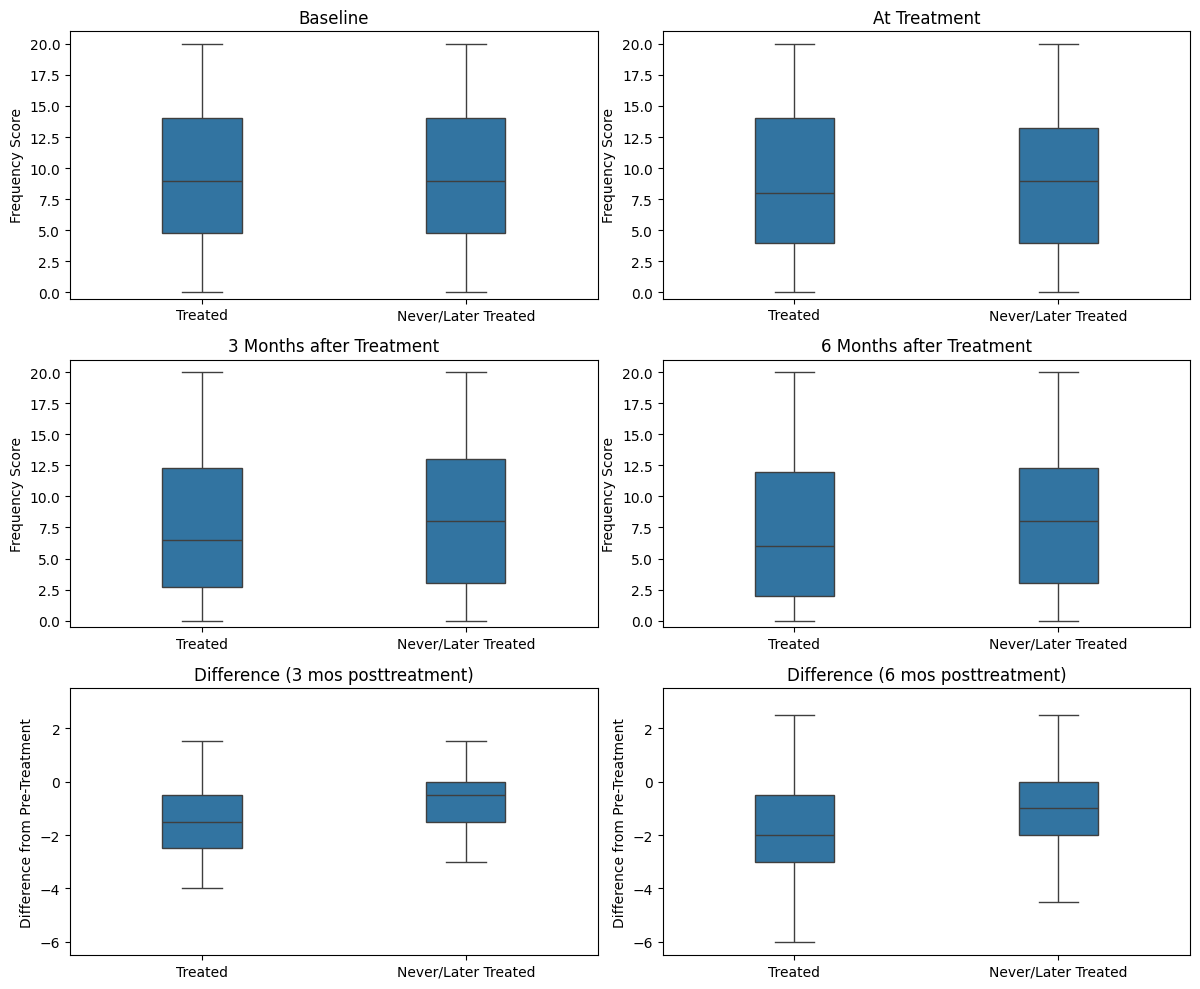

In [499]:
display_graph('frequency')